In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('quora_train.csv')
# df = df.sample(frac=0.10, random_state=99)
df.head(10)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   
8   8    17    18                    When do you use シ instead of し?   
9   9    19    20  Motorola (company): Can I hack my Charter Moto...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1  
6  What keeps childern active and far from phone ...             0  
7          What should I do to be a great geologist?             1  
8              When do you use "&" instead of "and"?             0  
9  How do I hack Motorola DCX3400 for free internet?             0

In [3]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [4]:
df.shape

(404290, 6)

In [5]:
df.dropna(axis=0, inplace=True)

In [6]:
df.shape

(404287, 6)

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

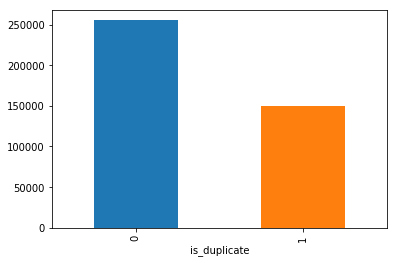

In [8]:
df.groupby("is_duplicate")['id'].count().plot.bar()

The classes are not perfectly balanced, but it is not bad, we are not going to balance it. 

In [9]:
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [10]:
df.shape

(404287, 3)

Preview a few question pairs

In [11]:
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?

Should I buy tiago?
What keeps childern active and far from phone and video games?

How can I be a good geologist?
What should I do to be a great geologist?

When do you use シ instea

There will be off a lot text cleaning to do.

The words like "what", "which" and "how" may have signals here, so I decided not to remove stop words. And I do plan to stem the words.

In [12]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
#     # all numbers should separate from words, this is too aggressive
    
#     def pad_number(pattern):
#         matched_string = pattern.group(0)
#         return pad_str(matched_string)
#     text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
#    def pad_pattern(pattern):
#        matched_string = pattern.group(0)
#       return pad_str(matched_string)
#    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [13]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)

In [34]:
a = 0 
for i in range(a,a+10):
    print(df.question1[i])
    print(df.question2[i])
    print()

what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market

what is the story of kohinoor kohinoor diamond
what would happen if the indian government stole the kohinoor kohinoor diamond back

how can i increase the speed of my internet connection while using a vpn
how can internet speed be increased by hacking through dns

why am i mentally very lonely how can i solve it
find the remainder when math2324math is divided by 2423

which one dissolve in water quikly sugar salt methane and carbon di oxide
which fish would survive in salt water

astrology i am a capricorn sun cap moon and cap risingwhat does that say about me
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me

should i buy tiago
what keeps childern active and far from phone and video games

how can i be a good geologist
what should i do to be a great geologist

when do you use  nonasciiword  instead of  nonasciiword 
when do y

In [18]:
X = df.loc[:, df.columns != 'is_duplicate']
y = df.loc[:, df.columns == 'is_duplicate']

### A simple Bag Of Words model

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Use FeatureUnion to combine the features from question1 and question2.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

transformer = FeatureUnion([
                ('question1_bow', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['question1'], 
                                                  validate=False)),
                            ('bow', 
                              CountVectorizer())])),
                ('question2_bow', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['question2'], 
                                                  validate=False)),
                            ('bow', 
                              CountVectorizer())]))])

In [21]:
X_train_count = transformer.fit_transform(X_train)
X_train_count.shape

(283000, 128314)

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train_count, y_train.values.ravel())
X_test_count = transformer.transform(X_test)
y_pred = rf.predict(X_test_count)
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.92      0.85     76647
           1       0.80      0.57      0.66     44640

   micro avg       0.79      0.79      0.79    121287
   macro avg       0.79      0.74      0.76    121287
weighted avg       0.79      0.79      0.78    121287



In [23]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_count, y_train.values.ravel())
X_test_count = transformer.transform(X_test)
y_pred = logreg.predict(X_test_count)
print(metrics.classification_report(y_test, y_pred))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.79      0.83      0.81     76647
           1       0.68      0.61      0.65     44640

   micro avg       0.75      0.75      0.75    121287
   macro avg       0.73      0.72      0.73    121287
weighted avg       0.75      0.75      0.75    121287



### Scaling Bag-of-Words with Tf-Idf Transformation

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_trfm = TfidfTransformer(norm=None)
X_train_count_tfidf = tfidf_trfm.fit_transform(X_train_count)
X_test_count_tfidf = tfidf_trfm.transform(X_test_count)
y_pred = rf.predict(X_test_count_tfidf)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82     76647
           1       0.80      0.41      0.54     44640

   micro avg       0.74      0.74      0.74    121287
   macro avg       0.76      0.67      0.68    121287
weighted avg       0.75      0.74      0.72    121287



In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

transformer = FeatureUnion([
                ('question1_tfidf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['question1'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('question2_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['question2'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())]))])

In [26]:
X_train_tfidf = transformer.fit_transform(X_train)
X_test_tfidf = transformer.transform(X_test)

In [27]:
X_train_tfidf.shape

(283000, 128314)

In [32]:
def randomforest_classify(X_tr, y_tr, X_test, y_test, description):
    ### Helper function to train a random forest classifier and score on test data
    m = RandomForestClassifier().fit(X_tr, y_tr)
    s = m.score(X_test, y_test)
    print ('Test score with', description, 'features:', s)
    return m

m_bow = randomforest_classify(X_train_count, y_train.values.ravel(), X_test_count, y_test.values.ravel(), 'bow')
m_tfidf = randomforest_classify(X_train_tfidf, y_train.values.ravel(), X_test_tfidf, y_test.values.ravel(), 'tf-idf')

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test score with bow features: 0.7880729179549334


C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Test score with tf-idf features: 0.784362709935937


In [54]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_tfidf, y_train.values.ravel())
X_test_tfidf = transformer.transform(X_test)
y_pred = logreg.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.86      0.82     76647
           1       0.71      0.58      0.64     44640

   micro avg       0.76      0.76      0.76    121287
   macro avg       0.74      0.72      0.73    121287
weighted avg       0.75      0.76      0.75    121287



In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train_tfidf, y_train.values.ravel())
X_test_tfidf = transformer.transform(X_test)
y_pred = rf.predict(X_test_tfidf)
print(metrics.classification_report(y_test, y_pred))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.78      0.92      0.84     76647
           1       0.80      0.55      0.65     44640

   micro avg       0.78      0.78      0.78    121287
   macro avg       0.79      0.74      0.75    121287
weighted avg       0.79      0.78      0.77    121287

